# multstars Tutorial

### Multstars is a statistical analysis package for Python. With multstars, you can determine the parameters of an underlying Gaussian distribution which would best fit observed projected separations between stellar multiples.

The likelihood that our data is drawn from a Gaussian distribution with center $\mu$ and width $\sigma_m$ is:

$$L = \sum^N_{i=1} \left( \frac{1}{\sqrt{2\pi}(\sigma_m^2+\sigma_i^2)} \, \exp\left({-\frac{(x_i-\mu)^2}{2(\sigma_m^2+\sigma_i^2)}}\right) \right)$$


First we'll import the required functions and data

In [1]:
# import the model
import multstars
from multstars.data_io import get_example_data_file_path, load_data
from multstars.model import log_likelihood, pymc3_fit

# additional imports for plotting
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
data_path = get_example_data_file_path('doubles_test.txt')
data = load_data(data_path)
data[:5]

,LSPM_ID,SEP_ANG,E_SEP_ANG,PA,E_PA,CONTRAST,E_CONTRAST,SIGNIFICANCE,SEP_PHYSICAL,E_SEP_PHYSICAL,MASSRATIO,E_MASSRATIO,DISTANCE_AGREEMENT,WDS_ID
0,J0324+3804,2.728916,0.07,322.322817,1.0,2.554220,0.078832,20.08,411.959254,2.750505,0.400159,0.018675,2.881536,NaN
1,J1939+1442,2.339860,0.07,180.081742,1.0,0.077536,0.008469,122.70,118.855224,0.108448,0.979492,0.019073,0.317884,J19392+1443
2,J1445+4922,0.869634,0.07,231.731009,3.0,0.777437,0.021475,45.90,87.094812,3.740179,0.745236,0.025981,0.838429,NaN
3,J2026+2730,0.202666,0.07,335.521763,7.0,2.600645,0.545514,NaN,6.204474,0.789402,0.427303,0.050383,NaN,NaN
4,J0731+3613S,1.526602,0.07,191.217158,2.0,2.701459,0.013702,28.87,18.318636,0.070316,0.402207,0.015455,3.785665,J07319+3613


Here we are only looking at the physical separations, let's take a look at their distribution.

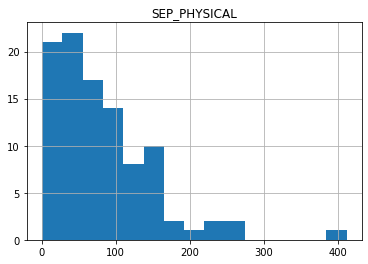

In [3]:
data.hist(column='SEP_PHYSICAL', bins=15);

Now we're going to look at the likelihoods for several gaussians fit to this distribution

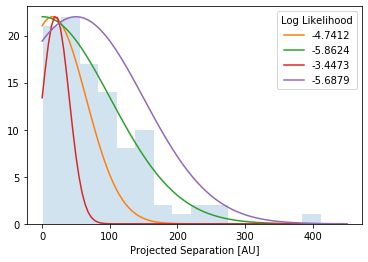

In [5]:
seps = np.linspace(0, 450, 100)
plt.hist(data['SEP_PHYSICAL'], alpha=.2, bins=15)

#tuples of the guesses for paramters mean and width of the gaussin
parameter_guesses = [[15, 50], [.7, 100], [20, 20], [50, 100]]  

for guess in parameter_guesses:
    center, width = guess
    likelihood_value = round(log_likelihood(data, center, width), 4)
    pdf_guess = norm.pdf(seps,center,width)
    scale = 22/np.max(pdf_guess)
    plt.plot(seps, pdf_guess*scale, label=str(likelihood_value))
    plt.xlabel('Projected Separation [AU]')
    plt.legend(title='Log Likelihood');

So our second guess ($\mu=20$ and width $\sigma_m=20$) was the best. But we can do better using emcee.

In [7]:
estimate = [20, 20]
ta = time.time()
samples = pymc3_fit(data, nsteps=1000)
tb = time.time()
print('Fit finished, took ',round((tb-ta)/60., 1),' minutes' )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [width, center]
Sampling chain 0, 121 divergences: 100%|██| 2000/2000 [00:10<00:00, 187.92it/s]
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Fit finished, took  0.9  minutes


center = 87.98 + 194.83 - 59.42
width = 23.8 + 354.2 - 21.9


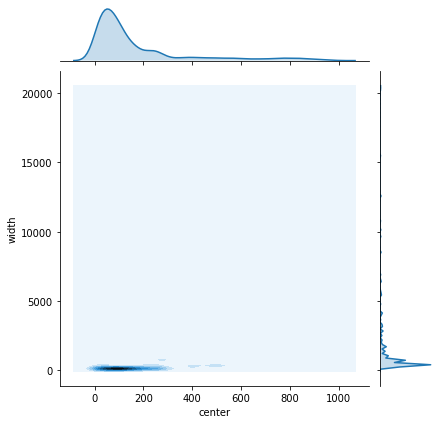

In [8]:
# estimate of the MAP
q = samples.quantile([0.16,0.50,0.84], axis=0)
c_lower, c, c_upper = q['center']
w_lower, w, w_upper = q['width']

print("center = {:.2f} + {:.2f} - {:.2f}".format(c, c_upper-c, c-c_lower))
print("width = {:.1f} + {:.1f} - {:.1f}".format(w, w_upper-w, w-w_lower))


sns.jointplot(x='center', y='width', data=samples, kind='kde');